# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**  

*Признаки*  

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя  

*Целевой признак*  

* Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgbm

import time
import warnings
warnings.filterwarnings('ignore')

* Прочитаем данные и сделаем первичный анализ

In [2]:
df = pd.read_csv("/datasets/autos.csv")
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В предоставленном датафрейме имеются пропуски, артефакты и лишняя информация. 

Посмотрим на дату формирования списков:

In [5]:
df.DateCreated.max()

'2016-04-07 00:00:00'

* Проведём предобработку данных для корректного обучения моделей в последующем

*Удалим не информативные (не влияющие на конечную цену автомобиля) столбцы:*

In [6]:
df = df.drop(["DateCrawled", "DateCreated", "RegistrationMonth", "NumberOfPictures", "PostalCode", "LastSeen"], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Остались только значимые признаки, определяющие итоговую стоимость.

*Многоие значения пропущены в столбце VehicleType.*

In [7]:
df["VehicleType"].isna().sum()

37490

Попробуем восстановить эти данные исходя из модели авто.

In [8]:
models_vehType = df.groupby("Model")['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()

def vehicle_type_inputer(row):
    
    model = row["Model"]
    veh_Type = row["VehicleType"]
    
    if model == "another" and veh_Type == "another":
        return "another"
    elif model == "another" and veh_Type != "another":
        return veh_Type
    
    return models_vehType[model]

df["Model"] = df["Model"].fillna("another")
df["VehicleType"] = df["VehicleType"].fillna("another")

df["VehicleType"] = df[["VehicleType", "Model"]].apply(vehicle_type_inputer, axis=1)

Проверим пропуски

In [9]:
df[df["VehicleType"]=="another"]["VehicleType"].count()

6828

Удалось избавиться более чем от 30 000 пропусков, отлично.

*Если значение пропущено в столбце NotRepaired, будем считать что ремонтов на автомобиле не было.*

In [10]:
df["NotRepaired"].fillna("yes", inplace=True)

*Осталось обработать пропуски в столбцах Gearbox и FuelType.*  
Так как данные параметры могут различаться даже у одной и той же модели, по этому просто заменим "NaN" на "another".

In [11]:
df[['Gearbox','FuelType']] = df[['Gearbox','FuelType']].fillna('another')

In [12]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

С пропусками разобрались.

* Следующим этапом проанализируем числовые признаки на наличие аномалий.

In [13]:
numeric_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

def plot_numeric(df, numeric_columns):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(numeric_columns, axes.ravel()):
        ax.set_title(column)
        sns.distplot(df[column], ax=ax)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(numeric_columns, axes.ravel()):
        ax.set_title(column)
        sns.boxplot(df[column], ax=ax)

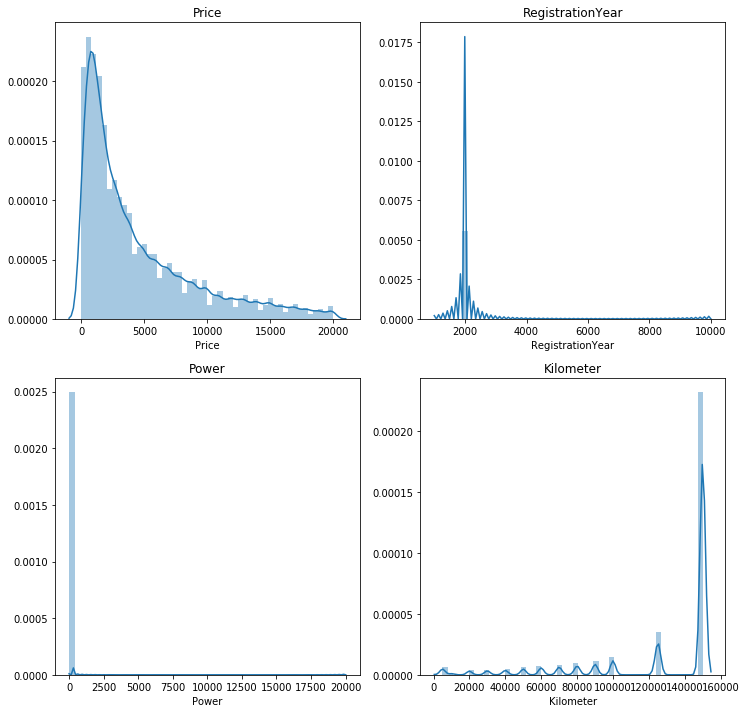

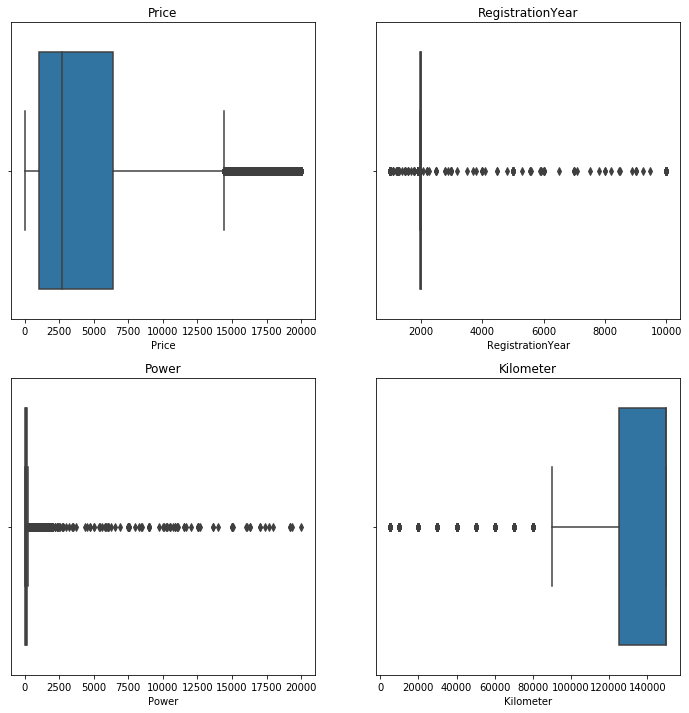

In [14]:
plot_numeric(df, numeric_columns)

*Price*

Удалим строки с 0 ценой, т.к. предсказывать таргет, который не существует - бессмысленно.

In [15]:
df=df.drop(df.index[df['Price']==0])

*RegistrationYear*

Определим, что машин младше 2016 года (год подачи самого позднего объявления), а так же старше 1960 года (начало современной эпохи автомобилестроения) - быть не должно.

In [16]:
print("Процент данных с ошибками по годам: {:.2%}".format(df
                                                          .query('RegistrationYear<1960 or RegistrationYear>2016')
                                                          .shape[0] / df.shape[0]))

Процент данных с ошибками по годам: 4.11%


Удалим данные с ошибками

In [17]:
df = df.loc[(df['RegistrationYear']>1960) & (df['RegistrationYear']<2017)]
print("Размер датафрейма:", df.shape)

Размер датафрейма: (329342, 10)


*Power*

Посмотрим, сколько у нас всего значений с нулевой мощностью

In [18]:
print("Записей с нулевой мощностью:", df[df['Power']==0].shape[0])

Записей с нулевой мощностью: 32653


Посчитаем среднюю мощность по модели, за исключением нулевых значений и 1% квантиля, заполним этими данными нулевую мощность. Обязательно учтем и аномально большую мощность - больше 99% квантиля

In [19]:
power_lower_quantile = df[df['Power']!=0]['Power'].quantile(.01)
power_higher_quantile = df[df['Power']!=0]['Power'].quantile(.99)

Power_dict = {}

for i, j in zip(df.query('Power>=@power_lower_quantile and Power<@power_higher_quantile')
                .groupby('Model')['Power'].mean().index, 
                df.query('Power>=@power_lower_quantile and Power<@power_higher_quantile')
                .groupby('Model')['Power'].mean().values):
    Power_dict[i] = round(j)

df.loc[((df['Power']<power_lower_quantile) | (df['Power']>=power_higher_quantile)), 'Power'] = df['Model'].map(Power_dict)
df = df.dropna()

In [20]:
df['Power'] = df['Power'].astype('int')
print("Размер датафрейма:", df.shape)

Размер датафрейма: (329341, 10)


Посмотрим на получившиеся распределения

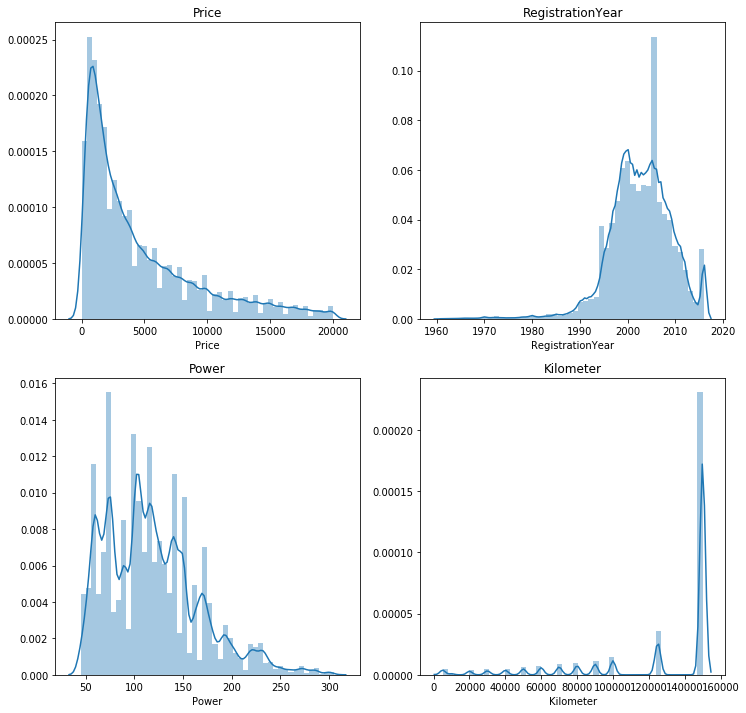

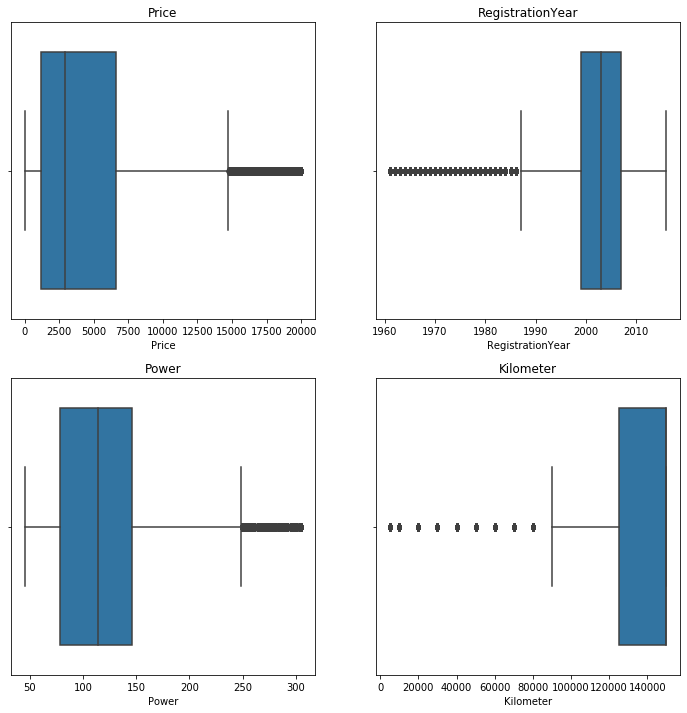

In [21]:
plot_numeric(df, numeric_columns)

*Распределения стали больше похожи на нормальные.*

Сбросим индексы после удаления лишних значений, и будем переходить к следующему этапу.

In [22]:
df=df.reset_index(drop=True)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,104,golf,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,another,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,1500,sedan,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
329336,1150,bus,2000,manual,125,zafira,150000,petrol,opel,no
329337,2200,another,2005,another,117,another,20000,another,sonstige_autos,yes
329338,1199,small,2000,auto,101,fortwo,125000,petrol,smart,no
329339,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


## Обучение моделей

* Разделим данные на основную выборку и целевые признаки

In [23]:
features=df.drop(['Price'],axis=1)
target=df['Price']

In [24]:
features.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

Выберем только категориальные признаки

In [25]:
col=['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'NotRepaired']

* Применим кодирование текстовых данных в категориальные цифровые значения методом OrdinalEncoder

In [26]:
encoder = OrdinalEncoder()
encoder.fit(features[col])
features_ord=features.copy()
features_ord[col]= pd.DataFrame(encoder.transform(features[col]), columns = features[col].columns)

#Выведем результат
features_ord.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,5.0,1993,2.0,104,117.0,150000,7.0,38.0,1.0
1,3.0,2011,2.0,190,40.0,125000,3.0,1.0,1.0
2,7.0,2004,1.0,163,118.0,125000,3.0,14.0,1.0
3,5.0,2001,2.0,75,117.0,150000,7.0,38.0,0.0
4,6.0,2008,2.0,69,102.0,90000,3.0,31.0,0.0


Определим тестовую и тренировочную выборку

In [27]:
train_features, test_features, train_target, test_target = train_test_split(
    features_ord,target, test_size=0.25, random_state=42)

#Проверим разделение
train_sample=train_features.shape[0]/features.shape[0]
test_sample=test_target.shape[0]/target.shape[0]
print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


* Применим масштабирование к нашим данным при помощи StandardScaler

In [28]:
numeric=['VehicleType','RegistrationYear','Gearbox','Power','Model','Kilometer','FuelType','Brand','NotRepaired']
scaler=StandardScaler()
scaler.fit(features_ord[numeric])

train_features[numeric]=scaler.transform(train_features[numeric])
test_features[numeric]=scaler.transform(test_features[numeric])

print(train_features.shape)
print(test_features.shape)

train_features.head()

(247005, 9)
(82336, 9)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
13289,-0.152006,0.503967,-3.143956,-0.308576,0.152608,0.580168,-0.986676,1.292936,-0.625387
148326,-2.296027,-1.006776,0.522477,-0.350441,1.665687,0.580168,-0.986676,1.292936,-0.625387
105513,-0.152006,0.806116,0.522477,0.068204,-1.417034,0.580168,0.734224,-1.413741,-0.625387
322416,0.383999,-0.553553,0.522477,-1.438918,0.958641,0.580168,0.734224,1.292936,-0.625387
212555,1.456010,-0.100330,0.522477,0.654307,-1.091793,-0.087778,0.734224,-1.488926,-0.625387


*Текстовые признаки трансформированы в цифровой формат, выборки разделены на тренировочную и тестовую - можно переходить к обучению моделей.*

* Для расчёта целевой метрики используем RMSE и напишем функцию.

In [29]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

Для понимания, какие факторы важны при моделировании, создадим функцию, используя feature_importances_

In [30]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.grid(True, linewidth = 0.4)
    plt.xlabel('Относительная важность')
    plt.show()

* **LinearRegression**

In [31]:
%%time
start = time.time()
model_lr=LinearRegression(normalize=True)
model_lr.fit(train_features,train_target)
end = time.time()
t_lr=round(end-start,2)

CPU times: user 73.5 ms, sys: 4.27 ms, total: 77.8 ms
Wall time: 90.6 ms


In [32]:
%%time
start = time.time()
predict_lr=model_lr.predict(test_features)
end = time.time()
t_lr_p=round(end-start,2)

CPU times: user 17.7 ms, sys: 74 µs, total: 17.7 ms
Wall time: 6.42 ms


In [33]:
print(' Гиперпараметры модели:\n',model_lr)

 Гиперпараметры модели:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [34]:
mae_lr=mean_absolute_error(test_target, predict_lr)
print('MAE модели LinearRegression равна:',mae_lr.round(2))
rmse_lr=rmse(test_target, predict_lr)
print('RMSE модели LinearRegression равна:', rmse_lr)

MAE модели LinearRegression равна: 2185.55
RMSE модели LinearRegression равна: 3074.12


* **RandomForestRegressor**

In [35]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=42, criterion='mse',warm_start=False, n_estimators=100)
model_rf.fit(train_features, train_target)
end = time.time()
t_rf=round(end-start,2)

CPU times: user 1min 11s, sys: 598 ms, total: 1min 11s
Wall time: 1min 13s


In [36]:
print(' Гиперпараметры модели:\n',model_rf)

 Гиперпараметры модели:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


In [37]:
%%time
start = time.time()
pred_rf=model_rf.predict(test_features)
end = time.time()
t_rf_p=round(end-start,2)

CPU times: user 3.66 s, sys: 0 ns, total: 3.66 s
Wall time: 3.67 s


In [38]:
mae_rf=mean_absolute_error(test_target, pred_rf)
print('MAE модели RandomForestRegressor равна:',mae_rf.round(2))
rmse_rf = rmse(test_target,pred_rf)
print('RMSE модели RandomForestRegressor равна:', rmse_rf)

MAE модели RandomForestRegressor равна: 1037.07
RMSE модели RandomForestRegressor равна: 1714.97


Факторы важности модели RandomForestRegressor

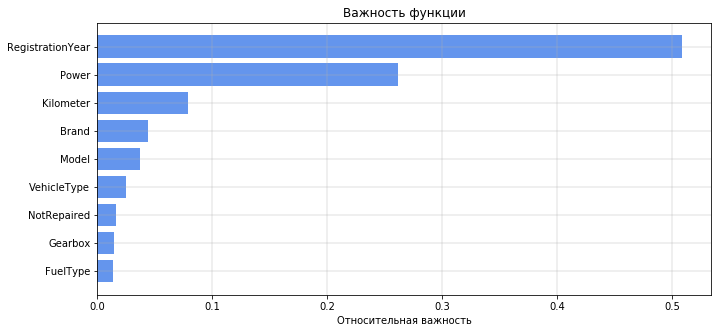

In [39]:
importances(model_rf,test_features)

* **CatBoostRegressor**

In [40]:
%%time
start = time.time()
model_cat = CatBoostRegressor(random_state=42,learning_rate=0.4, verbose=100,n_estimators=1000)
model_cat.fit(train_features, train_target, eval_set=(test_features,test_target))
end = time.time()
t_cat=round(end-start,2)

0:	learn: 3499.2163013	test: 3507.0507385	best: 3507.0507385 (0)	total: 206ms	remaining: 3m 25s
100:	learn: 1777.7697262	test: 1800.4000180	best: 1800.4000180 (100)	total: 19.6s	remaining: 2m 54s
200:	learn: 1702.5056146	test: 1751.7487419	best: 1751.7487419 (200)	total: 37.8s	remaining: 2m 30s
300:	learn: 1659.1973943	test: 1730.0567523	best: 1730.0567523 (300)	total: 55.6s	remaining: 2m 9s
400:	learn: 1626.1186630	test: 1713.5693608	best: 1713.5693608 (400)	total: 1m 13s	remaining: 1m 49s
500:	learn: 1601.6796984	test: 1704.3646281	best: 1704.3646281 (500)	total: 1m 31s	remaining: 1m 30s
600:	learn: 1581.1572992	test: 1695.8140838	best: 1695.5076017 (599)	total: 1m 49s	remaining: 1m 12s
700:	learn: 1563.3271446	test: 1689.6275042	best: 1689.6275042 (700)	total: 2m 6s	remaining: 54.2s
800:	learn: 1548.0107366	test: 1684.4251708	best: 1684.4251708 (800)	total: 2m 25s	remaining: 36s
900:	learn: 1535.0825421	test: 1680.9255424	best: 1680.7366502 (896)	total: 2m 42s	remaining: 17.8s
999:	

In [41]:
%%time
start = time.time()
predict_cat=model_cat.predict(test_features)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: user 164 ms, sys: 3.66 ms, total: 167 ms
Wall time: 132 ms


In [42]:
mae_cat=mean_absolute_error(test_target, predict_cat).round(2)
print('MAE модели CatBoostRegressor равна:',mae_cat.round(2))
rmse_cat=rmse(test_target, predict_cat)
print('RMSE модели CatBoostRegressor равна:', rmse_cat)

MAE модели CatBoostRegressor равна: 1042.74
RMSE модели CatBoostRegressor равна: 1678.66


Факторы важности модели CatBoostRegressor

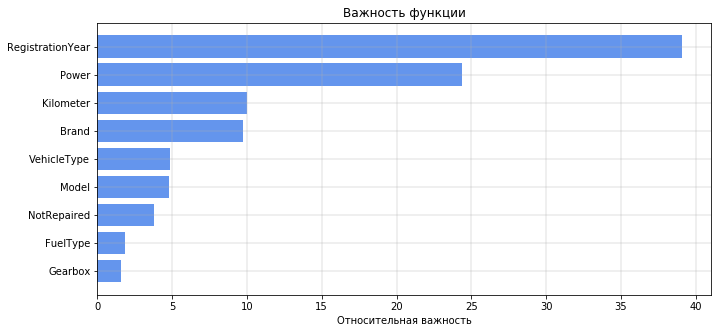

In [43]:
importances(model_cat,train_features)

* **LightGBM**

In [44]:
%%time
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=42, learning_rate=0.4, objective='rmse')
model_LGB.fit(train_features, train_target, eval_set=(test_features,test_target), verbose=100)
end = time.time()
t_lgb=round(end-start,2)

[100]	valid_0's rmse: 1729.26
[200]	valid_0's rmse: 1693.85
[300]	valid_0's rmse: 1678.14
[400]	valid_0's rmse: 1670.53
[500]	valid_0's rmse: 1666.77
[600]	valid_0's rmse: 1662.15
[700]	valid_0's rmse: 1662.13
[800]	valid_0's rmse: 1660.42
[900]	valid_0's rmse: 1659.85
[1000]	valid_0's rmse: 1659.76
CPU times: user 1min 3s, sys: 212 ms, total: 1min 3s
Wall time: 1min 4s


In [45]:
%%time
start = time.time()
predict_LGB= model_LGB.predict(test_features)
end = time.time()
t_lgb_p=round(end-start,2)

CPU times: user 6.93 s, sys: 0 ns, total: 6.93 s
Wall time: 7.2 s


In [46]:
print(' Гиперпараметры модели:\n',model_LGB)

 Гиперпараметры модели:
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.4, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective='rmse',
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [47]:
mae_gbm=mean_absolute_error(test_target, predict_LGB).round(2)
print('MAE модели LightGBM равна:',mae_gbm.round(2))
rmse_gbm=rmse(test_target, predict_LGB)
print('RMSE модели LightGBM равна:', rmse_gbm)

MAE модели LightGBM равна: 1021.95
RMSE модели LightGBM равна: 1659.76


Факторы важности модели LightGBM

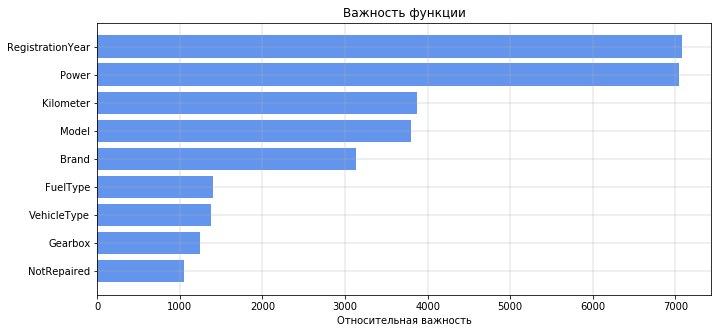

In [48]:
importances(model_LGB,train_features)

## Анализ моделей

Проанализируем скорость работы и качество моделей.

Для наглядности сведём все интересующие нас даные в таблицу

In [49]:
column=['RMSE модели','MAE модели','Скорость обучения, s','Скорость предсказания, s']

comparison_tabl = pd.DataFrame(index=[
    'RMSE модели','MAE модели','Скорость обучения, s', 'Скорость предсказания, s'], columns=[
    'LinearRegression','RandomForestRegressor','CatBoostRegressor','LightGBM'])
comparison_tabl['LinearRegression'] = rmse_lr, mae_lr, t_lr, t_lr_p
comparison_tabl['RandomForestRegressor'] = rmse_rf, mae_rf, t_rf, t_rf_p
comparison_tabl['CatBoostRegressor'] = rmse_cat,mae_cat, t_cat, t_cat_p
comparison_tabl['LightGBM'] = rmse_gbm,mae_gbm,t_lgb,t_lgb_p

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(
    null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели,MAE модели,"Скорость обучения, s","Скорость предсказания, s"
LinearRegression,3074.12,2185.55,0.09,0.01
RandomForestRegressor,1714.97,1037.07,73.03,3.67
CatBoostRegressor,1678.66,1042.74,183.02,0.13
LightGBM,1659.76,1021.95,64.8,7.2


Из данной таблице, мы видим следующее:

* Модель **LightGBM** на наших данных предсказала самую маленькую ошибку, но время предсказания у неё хуже чем у других;  
* Модель **CatBoost** так же показала не плохой результат по ошибке, при этом скорость предсказания у модели одна из самых быстрых;  
* **RandomForestRegressor** показала средний результат и по качеству предсказания и по скорости;  
* **LinearRegression** выдает очень большую ошибку. Не смотря на быстроту предсказаний использовать её в работе не имеет смысла.

**Общий вывод:**

**Для определения стоимости автомобиля, в приложении сервиса «Не бит, не крашен», следует использовать одну из двух моделей: CatBoostRegressor или LightGBM.  
CatBoostRegressor показывает хороший результат по точности предсказания и делает это очень быстро, что важно для он-лайн сервисов. Единственный её минус это долгий процесс обучения.   
LightGBM это лучший вариант по точности предсказания цены. Модель абсолютно парвильно расставляет приоритет важности факторов и однозначно подойдёт, если сервис будет делать ставку имменно на адекватность предсказания рыночной стоимости автомобиля.**